In [1]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
import math
from scipy import stats
import random
import sklearn
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error 
import warnings 
warnings.filterwarnings('ignore')

# In this section i implement basic functions for simulations of retutns and estiomation of sigmas and etas

In [2]:
# function for simulations of garch(1,1) process 
def simulate_GARCH(n, omega, alpha, beta=0):
    
    # Initialize our values
    sigma1 = math.sqrt(omega / (1 - alpha - beta))
    X = np.ndarray(n)
    sigma = np.ndarray(n)
    sigma[0] = sigma1
    for t in range(1, n):
        # Draw the next x_t
        X[t - 1] = sigma[t - 1] * np.random.normal(0, 1)
        # Draw the next sigma_t
        sigma[t] = math.sqrt(omega + beta * sigma[t - 1]**2 + alpha * X[t - 1]**2)
        
    X[n - 1] = sigma[n - 1] * np.random.normal(0, 1)    
    
    return X, sigma

In [3]:
# simulations of garch(2,2)
def simulate_GARCH_mod(n, omega, alpha1, alpha2, beta1=0, beta2=0):
    
    # Initialize our values
    sigma1 = 0.1
    X = np.ndarray(n)
    sigma = np.ndarray(n)
    sigma[0], sigma[1] = sigma1, sigma1
    X[0], X[1] = sigma1, sigma1
    for t in range(3, n):
        # Draw the next x_t
        X[t - 1] = sigma[t - 1] * np.random.normal(0, 1)
        # Draw the next sigma_t
        sigma[t] = math.sqrt(omega+beta1*sigma[t-1]**2+beta2*sigma[t-2]**2+alpha1*X[t-1]**2+alpha2*X[t-2]**2)
        
    X[n - 1] = sigma[n - 1] * np.random.normal(0, 1)    
    
    return X, sigma

In [4]:
def get_sigmas22(returns, theta):
    w, a1, a2, b1, b2 = theta[0], theta[1], theta[2], theta[3], theta[4]
    sigma1 = 0.1
    sigma2 = 0.1
    sigmas = [sigma1, sigma2]
    for i in range(len(returns)-2):
        sigmas.append(np.sqrt(w+a1*returns[i+1]**2+a2*returns[i]**2+b1*sigmas[-1]**2 +b2*sigmas[-2]**2))
    return sigmas   

In [5]:
def get_res(ret, sigma):
    return np.divide(ret, sigma)

# In this part we compare performance of GARCH and SVR in forecasting of square of returns 

## Right GARCH

### In this section I simulated a garch(2,2) process, then I fit a built in function to estimate coefficients of this process

In [6]:
#ret, sigma = simulate_GARCH(n=5000, omega=0.01, alpha=0.05, beta=0.9)
ret, tr_sigma = simulate_GARCH_mod(n=5000, omega=0.02, alpha1=0.25, alpha2 = 0.25, beta1=0.2, beta2=0.2)

In [7]:
ret

array([ 0.1       ,  0.1       ,  0.        , ..., -0.15164771,
       -0.43792731,  0.03303242])

In [8]:
theta = np.ndarray(5)
garch = arch_model(ret, p=2, q=2).fit(disp='off')
theta[0], theta[1], theta[2], theta[3], theta[4] = (garch.params['omega'],
                                                            garch.params['alpha[1]'],garch.params['beta[1]'],
                                                            garch.params['alpha[2]'], garch.params['beta[2]'])
# I want to compare estimated and real sigmas   
sigma = get_sigmas22(ret, theta)
print(sigma[-10:])
print(tr_sigma[-10:])

[0.2238510022372228, 0.2338957231841471, 0.18971279204225727, 0.19408198086877773, 0.19684768833373825, 0.204574462030359, 0.20161425435590474, 0.18843940884390067, 0.20314737805184882, 0.2919676147290785]
[0.24072756 0.24242715 0.21066417 0.21367021 0.21357892 0.22117998
 0.21555067 0.20803046 0.21869465 0.30317511]


In [9]:
#ret, sigma = np.append(ret, ret_mod), np.append(sigma, sigma_mod)
ret = ret[15:]
sigma = sigma[15:]
print(len(ret),len(sigma))

4985 4985


In [10]:
ret_train, ret_test, sigma_train, sigma_test = train_test_split(ret, sigma, test_size=0.2, random_state=0)

In [11]:
n = len(ret_train)
k = len(ret_test)

In [12]:
# get a list of resids 
eps_train = get_res(ret_train, sigma_train)
print(np.mean(eps_train))
print(np.std(eps_train))

0.011571532015348685
1.0458130413457842


(array([  1.,   0.,   2.,   0.,   0.,   1.,   0.,   0.,   4.,   1.,   6.,
          4.,   4.,   3.,   4.,   3.,  10.,  10.,  14.,  17.,  22.,  13.,
         20.,  23.,  17.,  29.,  29.,  51.,  46.,  60.,  57.,  82.,  82.,
         74.,  91., 101., 109., 103., 100., 131., 110., 118., 140., 136.,
        121., 122., 130., 129., 117., 120., 120., 104., 109.,  95., 113.,
        101.,  94.,  74.,  77.,  50.,  62.,  49.,  44.,  35.,  38.,  44.,
         25.,  22.,  28.,  28.,  15.,  17.,  14.,  10.,   8.,   9.,   7.,
          7.,   4.,   5.,   3.,   1.,   0.,   2.,   1.,   0.,   2.,   2.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-3.80726902, -3.72347341, -3.63967781, -3.5558822 , -3.47208659,
        -3.38829098, -3.30449537, -3.22069977, -3.13690416, -3.05310855,
        -2.96931294, -2.88551733, -2.80172173, -2.71792612, -2.63413051,
        -2.5503349 , -2.46653929, -2.38274368, -2.29894808, -2.21515247,
        -2.13135686, -2.04

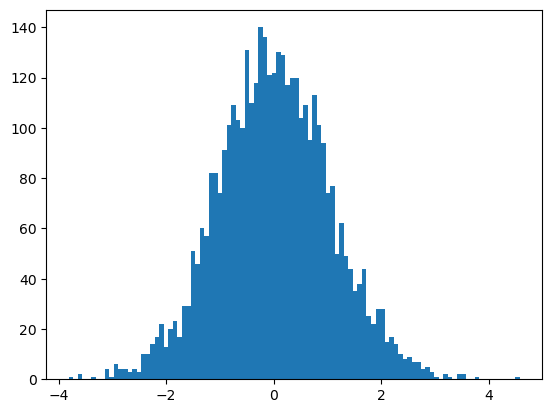

In [13]:
# check if the distribution is gausian
plt.hist(eps_train, bins=100)

In [14]:
#This function tests the null hypothesis that a sample comes from a normal distribution. 
# It is based on D’Agostino and Pearson’s 
#(https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html)

k2, p = stats.normaltest(eps_train)
alpha = 0.025

if p < alpha:  # null hypothesis: eps_train comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("eps_train comes from a normal distribution")

The null hypothesis can be rejected


In the next section first we fit a built-in garch model to our ret_train dataset, then using the estimated coefficients and list of sigmas, obtained from 'get_sigmas22(returns, theta)' function, we compute new sigma according to GARCH(2,2) formula
$\sigma_t^2 = \omega + \alpha_1*\varepsilon^2_{t-1}+\alpha_2*\varepsilon^2_{t-2} + \beta_1*\sigma_{t-1}^2 + \beta_2*\sigma_{t-2}^2 $

Then we obtain a random residiual $\hat{\eta}$ using $ random.randint() $ and , by multiplying  $\sigma_t^2$ by square of this residiual $\hat{\eta_t}^2$ we obtain $\hat{\varepsilon}_t^2$.

Then we add the $\hat{\varepsilon}_t^2$ to a list named 'pred', $\varepsilon_t^2$ to a list named 'real' and to our training set. Then we repeat our program. 

In the end we calculate MSE using built-in numpy functions.

In [15]:
pred = []
real = []
for i in range(k):
    # fit a built-in function to estimate coefficients 
    garch = arch_model(ret_train, p=2, q=2).fit(disp='off')
    #read coefficients 
    omega,a1,b1,a2,b2 = (garch.params['omega'], garch.params['alpha[1]'],
                          garch.params['beta[1]'], garch.params['alpha[2]'], garch.params['beta[2]'])
    #calculate sigma square
    pred_sigma2 = omega+a1*ret_train[-1]**2+b1*sigma_train[-1]**2+a2*ret_train[-2]**2+b2*sigma_train[-2]**2
    #pick random resid from eps
    eps = eps_train[random.randint(0, k)]
    pred.append((eps**2) *pred_sigma2)
    real.append(ret_test[0]**2)
    ret_train = np.append(ret_train, ret_test[0])
    ret_test = np.delete(ret_test, [0])
    sigma_train = np.append(sigma_train, sigma_test[0])
    sigma_test = np.delete(sigma_test, [0])

mse_garch = np.square(np.subtract(np.array(pred), np.array(real))).mean()
print('MSE for GARCH: ', mse_garch)    

MSE for GARCH:  0.33531946129445456


# SVR

In [16]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

In [18]:
# predict square of returns
ret_train, ret_test= train_test_split(np.power(ret,2), test_size=0.2, random_state=0)

In [19]:
# reshape to an appropriate forma
ret_train = ret_train.reshape(-1, 1)
ret_test = ret_test.reshape(-1,1)
ret_test.shape

(997, 1)

In [20]:
# scaling to ensure the data is projected in the interval 0,1.
scaler = MinMaxScaler()
sigma_train = scaler.fit_transform(ret_train)

In [21]:
train_data = ret_train
test_data = ret_test

# in this section i used this guide https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/3-SVR/README.md

# forecasting horizont
timesteps=5

train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]

x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3984, 4) (3984, 1)
(993, 4) (993, 1)


In [22]:
# hyperparameters tuning
param_grid = {'C': [0.1,1, 10], 'gamma': [1,'auto','scale',10000],'kernel': ['rbf','poly', 'sigmoid']}
#grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=2)
grid = SVR(C=1, gamma=1, kernel='poly')

In [23]:
grid.fit(x_train, y_train[:,0])

SVR(C=1, gamma=1, kernel='poly')

In [24]:
#print(grid.best_estimator_)

In [25]:
y_train_pred = grid.predict(x_train).reshape(-1,1)
y_test_pred = grid.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(3984, 1) (993, 1)


In [26]:
mse_svr = np.square(np.subtract(y_test_pred, y_test)).mean()
print('MSE for SVR ', mse_svr)

MSE for SVR  0.1501884571289235


# Misspecified GARCH

In [27]:
ret_train, ret_test, sigma_train, sigma_test = train_test_split(ret, sigma, test_size=0.2, random_state=0)

In [28]:
pred = []
real = []

for i in range(k):

    garch = arch_model(ret_train,vol='GARCH', p=1, q=1).fit(disp='off')
    omega,alpha, beta = garch.params['omega'], garch.params['alpha[1]'], garch.params['beta[1]']
    vol_pred = omega + alpha* ret_train[-1]**2 + beta* sigma_train[-1]**2
    eps = eps_train[random.randint(0, k)]
    pred.append(eps**2*vol_pred)
    real.append(ret_test[0]**2)
    ret_train = np.append(ret_train, ret_test[0])
    ret_test = np.delete(ret_test, [0])
    sigma_train = np.append(sigma_train, sigma_test[0])
    sigma_test = np.delete(sigma_test,[0])
    
mse_garch = np.square(np.subtract(np.array(pred), np.array(real))).mean()
print('MSE for misspecified GARCH: ', mse_garch)    

MSE for misspecified GARCH:  0.2669135875108104


# Summary:
## MSE for GARCH:  0.16332370943846017
## MSE for SVR  0.25127873840770076
## MSE for misspecified GARCH:  0.17337065681028271

# Different approach 

### In this section we used $\hat{\sigma}^2$ instead of $\hat{\varepsilon}^2$ to evaluate the model. All steps are the same exept for multiplyung $\hat{\sigma}^2$ by $\hat{\eta}^2$. So we evaluate performance of model using only $\sigma$. 

## Correct Garch. Fit Garch(2,2) on simulated Garch(2,2)

In [29]:
ret_train, ret_test, sigma_train, sigma_test = train_test_split(ret, sigma, test_size=0.2, random_state=0)

In [30]:
pred = []
real = []

for i in range(k):

    garch = arch_model(ret_train,vol='GARCH', p=2, q=2).fit(disp='off')
    omega,a1,b1,a2,b2 = (garch.params['omega'], garch.params['alpha[1]'], garch.params['beta[1]'],
                         garch.params['alpha[2]'], garch.params['beta[2]'])
    #calculate sigma square
    pred_sigma2 = omega+a1*ret_train[-1]**2+b1*sigma_train[-1]**2+a2*ret_train[-2]**2+b2*sigma_train[-2]**2
    pred.append(pred_sigma2)
    real.append(sigma_test[0]**2)
    ret_train = np.append(ret_train, ret_test[0])
    ret_test = np.delete(ret_test, [0])
    sigma_train = np.append(sigma_train, sigma_test[0])
    sigma_test = np.delete(sigma_test,[0])
    
mse_garch = np.square(np.subtract(np.array(pred), np.array(real))).mean()
print('MSE for GARCH: ', mse_garch)    

MSE for GARCH:  0.08530023566433391


## Misspecified Garch. Fit Garch(1,1) on simulated Garch(2,2)

In [31]:
ret_train, ret_test, sigma_train, sigma_test = train_test_split(ret, sigma, test_size=0.2, random_state=0)

In [32]:
pred = []
real = []

for i in range(k):

    garch = arch_model(ret_train,vol='GARCH', p=1, q=1).fit(disp='off')
    omega,alpha, beta = garch.params['omega'], garch.params['alpha[1]'], garch.params['beta[1]']
    #calculate sigma square
    pred_sigma2 = omega + alpha* ret_train[-1]**2 + beta* sigma_train[-1]**2
    pred.append(pred_sigma2)
    real.append(sigma_test[0]**2)
    ret_train = np.append(ret_train, ret_test[0])
    ret_test = np.delete(ret_test, [0])
    sigma_train = np.append(sigma_train, sigma_test[0])
    sigma_test = np.delete(sigma_test,[0])
    
mse_garch = np.square(np.subtract(np.array(pred), np.array(real))).mean()
print('MSE for misspecified GARCH: ', mse_garch)    

MSE for misspecified GARCH:  0.08445365049376717


# SVR

In [33]:
# predict square of returns
sigma_train, sigma_test= train_test_split(np.power(sigma,2), test_size=0.2, random_state=0)
# reshape to an appropriate forma
sigma_train = sigma_train.reshape(-1, 1)
sigma_test = sigma_test.reshape(-1,1)
sigma_test.shape

(997, 1)

In [34]:
# scaling to ensure the data is projected in the interval 0,1.
scaler = MinMaxScaler()
sigma_train = scaler.fit_transform(sigma_train)

In [35]:
train_data = sigma_train
test_data = sigma_test

# in this section i used this guide https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/3-SVR/README.md

# the inputs to the model are the data for the first 4 timesteps, 
#and the output will be the data for the 5th timestep.
timesteps=5

train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]

x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# hyperparameters tuning
param_grid = {'C': [1], 'gamma': ['auto','scale',10000],'kernel': ['rbf','poly', 'sigmoid']}
grid = SVR(C=1, gamma=10000)
#GridSearchCV(SVR(),param_grid,refit=True,verbose=2)

(3984, 4) (3984, 1)
(993, 4) (993, 1)


In [36]:
grid.fit(x_train, y_train[:,0])

SVR(C=1, gamma=10000)

In [37]:
#print(grid.best_estimator_)

In [38]:
y_train_pred = grid.predict(x_train).reshape(-1,1)
y_test_pred = grid.predict(x_test).reshape(-1,1)

In [39]:
len(y_test_pred)

993

In [40]:
mse_svr = np.square(np.subtract(y_test_pred, y_test)).mean()
print('MSE for SVR ', mse_svr)

MSE for SVR  0.044789604973264674


## MSE for GARCH:  0.033034330206868835
## MSE for misspecified GARCH:  0.03997916389250524
## MSE for SVR  0.044789604973264674